# List 1 of Machine Learning (*part 2, question 5*)
# Professor PhD. Daniel Guerreiro
# 28th september, 2025

**Note:** this code requires the `pandas` and `matplotlib` Python packages, as well as jupyter notebook. Please download them using the `requirements.txt` file. Python version must be 3.10 or greater.

## 0. Student identification

* **Name:** Thiago Tomás de Paula
* **Number:** 242104677
* **Association to University of Brasília:** student of the mechanical sciences graduate program (msc.)

## 1. Presenting the question

Consider the dataset of 3000 **bivariate**, **labeled** samples in `data.csv` file. 
Firstly, split the dataset into **training (70%)** and **test set (30%)**.

a) 
Assume the samples labeled with “+1” are drawn by a bivariate gaussian density with parameters $\bm\mu_{+1}$, $\bm\Sigma_{+1}$, 
while the samples labeled with “-1” are drawn by another gaussian density with parameters $\bm\mu_{-1}$, $\bm\Sigma_{-1}$. 

The prior probabilities $P(C_{+1})$ e $P(C_{-1})$ are unknownas well. 
Estimate the missing parameters (with the training set), 
present the discriminant functions of the Bayes classifier (MAP criterion) and 
evaluate its performance (accuracy, precision, recall) over the **test** set. 
Comment all your results.

b)
Calculate the decision boundary and plot it on a graph with the samples of the test set.
Comment your results.

## 2. Solution

The answers to the question are presented below. In [section 2.1](#21-data-modeling-and-train-test-split) modeling of the data as features is presented, and the dataset is split; then [sections 2.2](#22-missing-parameters-estimation) through [2.4](#24-performance-evaluation) answer item (a), and finally [section 2.5](#25-decision-boundary) plots and analyses the decision boundary as asked in (b).

### 2.1. Data modeling and train-test split 

Firstly, we must load the dataset from the given CSV file. Assuming this file is in the same directory as this notebook, and that it is named `data.csv`, the snippet below loads it as a [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) object defined in the [`pandas`](https://pandas.pydata.org/) data analysis library.

In [17]:
import pandas as pd

data = pd.read_csv("data.csv", names=["x1", "x2", "distribution"])
data.index.name = "original index"
data.reset_index(inplace=True)

For a sanity check, here are the **5 first lines** of the loaded dataset:

In [18]:
display(data.head())

,original index,x1,x2,distribution
0,0,5.395614,-5.493840,1
1,1,4.448487,-2.612584,1
2,2,6.712395,-2.995796,1
3,3,7.144932,-1.515026,1
4,4,5.772944,-7.589843,1


Now, the function below splits the dataset such that a proportion $0<$`p`$<1$ of it set is separated for training, and the remaining `1-p`, for testing. 
Note that the original samples are **shuffled** in order to avoid estimation bias in the training set.

In [19]:
def train_test_split(original_dataset: pd.DataFrame, p: float = 0.7, seed: int = 242104677) -> tuple[pd.DataFrame]:
    """Split the dataset into training and testing sets.

    Args:
        original_dataset (pd.DataFrame): The original dataset to split.
        p (float, optional): The proportion of the dataset to include in the training set. Defaults to 0.7 (70%).
        seed (int, optional): The random seed for reproducibility. Defaults to 242104677.

    Returns:
        tuple[pd.DataFrame]: The shuffled, training and testing datasets.

    Raises:
        ValueError: If the proportion p is not between 0 and 1 exclusive.
    """

    if not 0 < p < 1:
        raise ValueError("Proportion p must be between 0 and 1 exclusive.")

    # Shuffle the dataset to avoid bias
    shuffled_dataset = original_dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Calculate the split index
    split_index = int(len(shuffled_dataset) * p)
    
    # Split the dataset
    train_set = shuffled_dataset.iloc[:split_index, :]
    test_set = shuffled_dataset.iloc[split_index:, :]

    return shuffled_dataset, train_set, test_set

The code below applies the above function, splitting the original dataset.

In [20]:
# Apply the split
proportion = 0.7
shuffled_samples, train_samples, test_samples = train_test_split(data, p=proportion)

To visualize the effects of the suffling.\
The top row of plots show how the splits changed, while the bottom row shows how the original order of samples changed.\
Notably, most values of class -1 were at the end of the CSV, indicating that the suffle was a good idea.\
Red points belong to the training set (or *would* belong, when referring to the original data), while burnt yellow points (would) belong to the testing set.

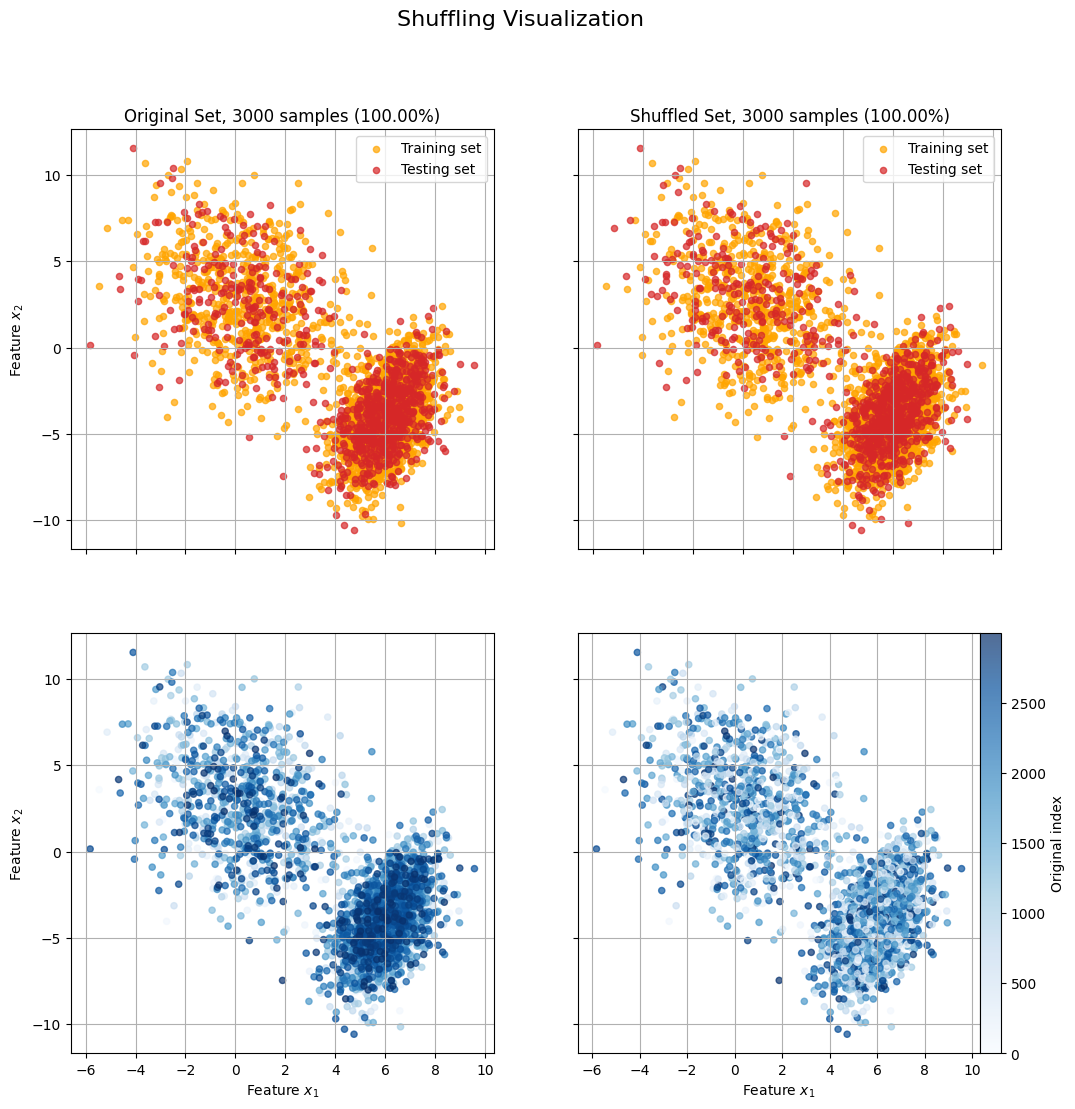

In [21]:
# Plots: original and shuffled datasets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex=True, sharey=True)
fig.suptitle("Shuffling Visualization", fontsize=16)

for ax, split, label in zip(
    axs.flatten()[:2], 
    (data, shuffled_samples), 
    ("Original", "Shuffled")
):
    # Points that would go to training set 
    split.iloc[:int(proportion * split.shape[0]), :].plot.scatter(
        x="x1", y="x2", 
        c="orange", 
        title=f"{label} Set, {split.shape[0]} samples (100.00%)",
        ax=ax, grid=True, alpha=0.7, label="Training set"
    )
    # Points that would go to testing set 
    split.iloc[int(proportion * split.shape[0]):, :].plot.scatter(
        x="x1", y="x2", 
        c="tab:red", 
        ax=ax, grid=True, alpha=0.7, label="Testing set"
    )
    ax.set_xlabel("Feature $x_1$")
    ax.set_ylabel("Feature $x_2$")

for ax, split in zip(
    axs.flatten()[2:], 
    (data, shuffled_samples)
):
    # Points colored by initial index
    split.plot.scatter(
        x="x1", y="x2", 
        colormap="Blues", c="original index", colorbar=False,
        ax=ax, grid=True, alpha=0.7
    )
    ax.set_xlabel("Feature $x_1$")
    ax.set_ylabel("Feature $x_2$")

# Colorbar adjustment
cb = plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 1], orientation="vertical", fraction=0.05, pad=0)
cb.set_label("Original index")

To finish this section, here is the presentation of the train and test sets that will be used in the following sections of this notebook. Note that they came from the plot above, of the shuffled data.

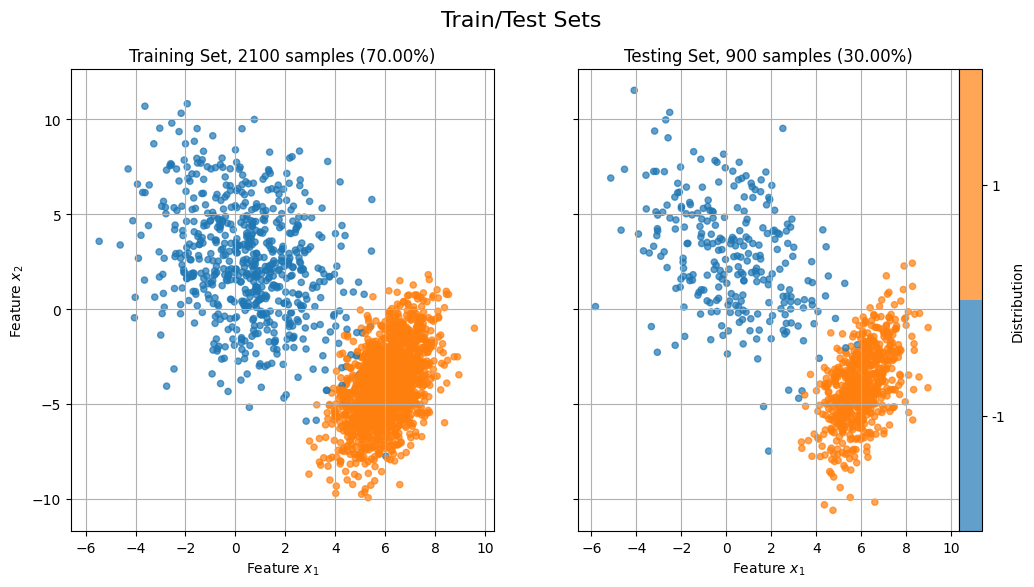

In [22]:
# Plots: training and testing datasets
from matplotlib.colors import ListedColormap
cmap_distribution = ListedColormap(['tab:blue', 'tab:orange'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
fig.suptitle("Train/Test Sets", fontsize=16)

for ax, split, title in zip(
    axs, 
    (train_samples, test_samples), 
    ("Training", "Testing")
):

    percentage = proportion if title == "Training" else (1 - proportion)

    split.plot.scatter(
        x="x1", y="x2", 
        c="distribution", colormap=cmap_distribution, colorbar=False,
        title=f"{title} Set, {split.shape[0]} samples ({percentage * 100 :.2f}%)", 
        ax=ax, grid=True, alpha=0.7,
    )
    ax.set_xlabel("Feature $x_1$")
    ax.set_ylabel("Feature $x_2$")

# Colorbar adjustment
cb = plt.colorbar(axs[-1].collections[0], ticks=[-0.5, 0.5], ax=axs[1], orientation="vertical", fraction=0.1, pad=0)
cb.set_ticklabels([-1, 1])
cb.set_label("Distribution")

### 2.2 Missing parameters estimation 

Moving forward, we need estimations of the following parameters:

* $\widehat{P}(C_{+1})$, the prior of class $C_{+1}$;  
* $\widehat{P}(C_{-1})$, the prior of class $C_{-1}$; 
* $\widehat{\bm\mu}_{+1}$, the mean of class $C_{+1}$; 
* $\widehat{\bm\mu}_{-1}$, the mean of class $C_{+1}$; 
* $\widehat{\bm\Sigma}_{+1}$, the covariance matrix of class $C_{+1}$; 
* $\widehat{\bm\Sigma}_{-1}$, the covariance matrix of class $C_{-1}$. 

The estimators for the priors and means are simple enough, and unbiased:

$
    \begin{align}
        \widehat{P}(C_i) &= 
            \frac{N_i}
                 {N_{+1} + N_{-1}} \\
        \widehat{\bm{\mu}}_i &= 
            \frac{1}{N_i}
            \sum_{n=1}^{N_i} \mathbf{x}^n_i   
    \end{align}
$

with $N_i$ the number of appearences of class $C_i$ in the training split and $\mathbf{x}^n_i$ the $n$-th feature vector ($\mathbf{x}=[x_1\ x_2]^\top$) in the training data that is in class $C_i$.
The covariance estimators are a little more complicated and also biased (although the bias is negligible since the sample size is large):

$
    \begin{align}
        \widehat{\bm\Sigma}_i = 
        \frac{1}{N_i} 
        \sum_{n=1}^{N_i} 
            (\mathbf{x}^n_i - \widehat{\bm\mu}_i)
            (\mathbf{x}^n_i - \widehat{\bm\mu}_i)^\top 
    \end{align}
$

The snippet below calculates these estimators using `pandas`' methods. 

In [23]:
prior_estimates = train_samples["distribution"].value_counts(normalize=True).sort_index()
mean_estimates = train_samples.groupby("distribution")[["x1", "x2"]].mean()
covariance_estimates = train_samples.groupby("distribution")[["x1", "x2"]].cov()

The values obtained were the following, showing that roughly 70% of data is from class +1, and 30% from class -1.

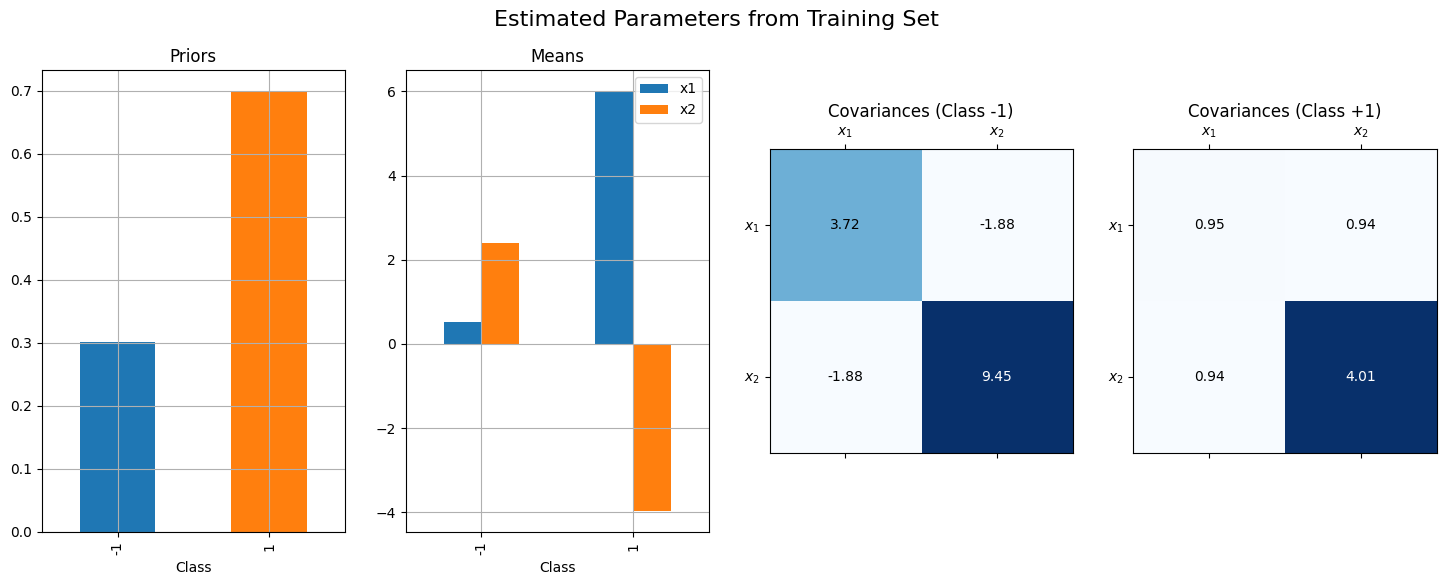

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
fig.suptitle("Estimated Parameters from Training Set", fontsize=16)

for ax, estimate, title in zip(
    axs[:2], 
    (prior_estimates, mean_estimates),
    ("Priors", "Means")
):
    estimate.plot.bar(
        ax=ax, 
        color=["tab:blue", "tab:orange"],
        grid=True,
    )
    ax.set_title(f"{title}")
    ax.set_xlabel("Class")

for ax, estimate, class_name in zip(
    axs[2:], 
    (covariance_estimates.loc[-1], covariance_estimates.loc[1]),
    ("-1", "+1")
):
    ax.matshow(estimate, cmap="Blues")
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f"{estimate.iloc[i, j]:.2f}", ha="center", va="center", color="white" if i==1 and j==1 else "black")
    ax.set_title(f"Covariances (Class {class_name})")
    ax.set_xticks([0, 1], labels=["$x_1$", "$x_2$"])
    ax.set_yticks([0, 1], labels=["$x_1$", "$x_2$"])



**Note.**\
Technically, the variables above aren't vectors/matrices in the structure presented in equations (1)-(3), but data objects with idiosyncratic indexing. 
For example, `covariance_estimates` represents **both** covariance matrices at **once**, as if they were stacked together. The colormaps displayed show the matrices as matrices.

To finish this section, here is a display of the estimated means on top of the training data in feature space. Indicated in dashed line is the Mahanalobis distance obtained using the estimated covariances, stretched to include two standard deviations of data.

Text(0, 0.5, 'Feature $x_2$')

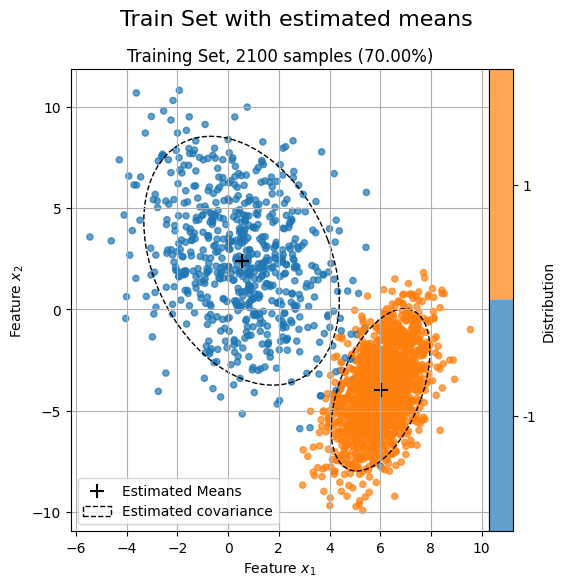

In [25]:
fig, axs = plt.subplots(figsize=(6, 6))
fig.suptitle("Train Set with estimated means", fontsize=16)

train_samples.plot.scatter(
    x="x1", y="x2", 
    c="distribution", colormap=cmap_distribution, colorbar=False,
    title=f"Training Set, {train_samples.shape[0]} samples ({proportion * 100 :.2f}%)", 
    ax=axs, grid=True, alpha=0.7,
)

# Colorbar adjustment
cb = plt.colorbar(axs.collections[0], ticks=[-0.5, 0.5], ax=axs, orientation="vertical", fraction=0.1, pad=0)
cb.set_ticklabels([-1, 1])
cb.set_label("Distribution")

plt.scatter(
    mean_estimates["x1"], 
    mean_estimates["x2"], 
    color="black", marker="+", s=100, label="Estimated Means"
)

def mahanalobis_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    from matplotlib.patches import Ellipse
    import numpy as np

    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Angle of the ellipse
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height of the ellipse
    width, height = 2 * n_std * np.sqrt(vals)

    # Create the ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellipse)
    return ellipse

for class_value in mean_estimates.index:
    mean = mean_estimates.loc[class_value].values
    cov = covariance_estimates.loc[class_value].values.reshape(2, 2)
    mahanalobis_ellipse(
        mean, 
        cov, 
        ax=axs, 
        edgecolor="black", 
        facecolor="none", 
        linestyle="--", 
        label=f"Estimated covariance" * (class_value == 1)  # only label once
    )

axs.legend(loc="lower left")
axs.set_xlabel("Feature $x_1$")
axs.set_ylabel("Feature $x_2$")

From the results of the section, it's safe to assume that the estimators give good representations of the data.\
Should there be misclassifications, they should appear for samples such that $2.5 \leq x_1 \leq 5.5$ and $-6 \leq x_2 \leq 0$,
that is, where the Mahanalobis ellipses presented in the above picture would "kiss". 

### 2.3 Discriminant functions

Since we have only two distributions that are assumed gaussian, it is advantageous to choose log odds as the discriminant:

$
    \begin{align}
        g(\mathbf{x}) 
        &= 
        \log\frac{P(C_{+1} | \mathbf{x})}
             {P(C_{-1} | \mathbf{x})} \\
        &= 
        \log\frac{p(\mathbf{x} | C_{+1})}
             {p(\mathbf{x} | C_{-1})} \\
        &=
        -\frac{1}{2}
            (|\widehat{\bm\Sigma}_{+1}| - |\widehat{\bm\Sigma}_{-1}|)
        -\frac{1}{2}
            (\mathbf{x} - \widehat{\bm\mu}_{+1})^\top \widehat{\bm\Sigma}^{-1}_{+1}
            (\mathbf{x} - \widehat{\bm\mu}_{+1})
        +\frac{1}{2}
            (\mathbf{x} - \widehat{\bm\mu}_{-1})^\top \widehat{\bm\Sigma}^{-1}_{-1}
            (\mathbf{x} - \widehat{\bm\mu}_{-1})
        + \log
            \frac{\widehat{P}(C_{+1})}
                 {\widehat{P}(C_{-1})}
    \end{align}
$

The presence of the priors at the right hand side shows that $g$ follows the MAP criterion.
Then, for each sample in the **test** set, 

$
    \begin{align}
        \text{Assigned class}(\mathbf{x}) = 
        \begin{cases}
            C_{+1}, & g(\mathbf{x}) > 0 \\
            C_{-1}, & g(\mathbf{x}) \leq 0
        \end{cases}
    \end{align}
$

### 2.4 Performance evaluation

First, the results are generated applying equations (7) and (6) to the test set:

In [26]:
import numpy as np

def log_odds_discriminant(x, mean1, cov1, prior1, mean2, cov2, prior2) -> float:
    """Equation (6) from the notebook"""
    
    inv_cov1 = np.linalg.inv(cov1)
    inv_cov2 = np.linalg.inv(cov2)
    det_cov1 = np.linalg.det(cov1)
    det_cov2 = np.linalg.det(cov2)

    quadratic_term = -0.5 * (x - mean1).T @ inv_cov1 @ (x - mean1) + 0.5 * (x - mean2).T @ inv_cov2 @ (x - mean2)
    linear_term = -0.5 * (np.log(det_cov1) - np.log(det_cov2))
    constant_term = np.log(prior1 / prior2)

    return quadratic_term + linear_term + constant_term

def assign_classes(test_set, mean_estimates, covariance_estimates, prior_estimates) -> pd.DataFrame:
    """Equation (7) from the notebook"""
    
    assigned_classes = {"x1": [], "x2": [], "distribution": []}

    mean1 = mean_estimates.loc[1].values
    cov1 = covariance_estimates.loc[1].values.reshape(2, 2)
    prior1 = prior_estimates.loc[1]

    mean2 = mean_estimates.loc[-1].values
    cov2 = covariance_estimates.loc[-1].values.reshape(2, 2)
    prior2 = prior_estimates.loc[-1]

    for _, row in test_set.iterrows():

        x = row[["x1", "x2"]].values
        g = log_odds_discriminant(x, mean1, cov1, prior1, mean2, cov2, prior2)
        assigned_class = 1 if g > 0 else -1

        assigned_classes["x1"].append(row["x1"])
        assigned_classes["x2"].append(row["x2"])
        assigned_classes["distribution"].append(assigned_class)

    return pd.DataFrame(assigned_classes)

In [27]:
assignments = assign_classes(test_samples, mean_estimates, covariance_estimates, prior_estimates)

Then, it is plotted against the expected values, confirming the guess in the previous section about where misclassifications would appear:

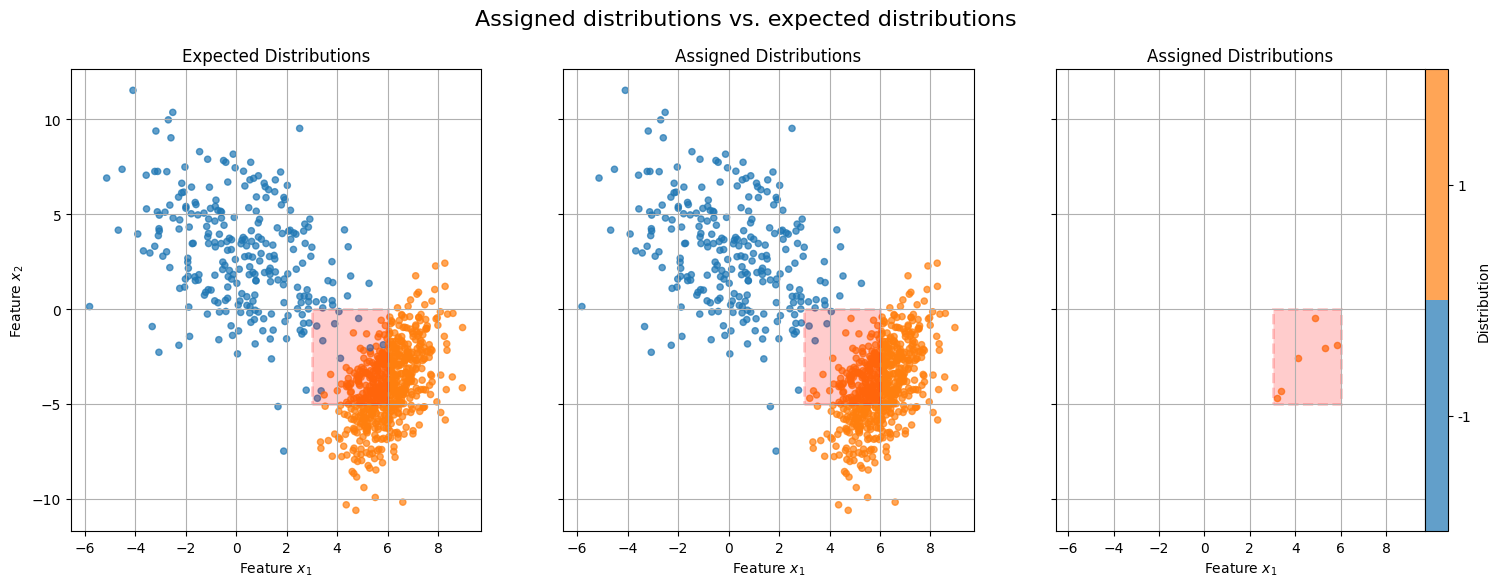

In [28]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharex=True, sharey=True)
fig.suptitle("Assigned distributions vs. expected distributions", fontsize=16)

errors = assignments[assignments["distribution"] != test_samples["distribution"].reset_index(drop=True)]

for ax, dataset, title in zip(
    axs[:2], 
    (test_samples, assignments, errors),
    ("Expected Distributions", "Assigned Distributions")
):
    ax.set_title(title)
    dataset.plot.scatter(
        x="x1", y="x2",
        c="distribution", colormap=cmap_distribution, colorbar=False,
        ax=ax, grid=True, alpha=0.7,
    )
    # Red rectangle around the misslabeled samples
    ax.add_patch(Rectangle((3, -5), 3, 5, facecolor="red", ec="red", alpha=0.2, linestyle="--", linewidth=2))
    ax.set_xlabel("Feature $x_1$")
    ax.set_ylabel("Feature $x_2$")
    ax.set_title(title)

axs[2].set_title("Missclassified Samples")
errors[errors["distribution"] == -1].plot.scatter(
    x="x1", y="x2", color="tab:blue",
    ax=axs[2], grid=True, alpha=0.7,
)
errors[errors["distribution"] == 1].plot.scatter(
    x="x1", y="x2", color="tab:orange",
    ax=axs[2], grid=True, alpha=0.7,
)
# Red rectangle around the misslabeled samples
axs[2].add_patch(Rectangle((3, -5), 3, 5, facecolor="red", ec="red", alpha=0.2, linestyle="--", linewidth=2))
axs[2].set_xlabel("Feature $x_1$")
axs[2].set_ylabel("Feature $x_2$")
axs[2].set_title(title)

# Colorbar adjustment
cb = plt.colorbar(axs[1].collections[0], ticks=[-0.5, 0.5], ax=axs[2], orientation="vertical", fraction=0.1, pad=0)
cb.set_ticklabels([-1, 1])
cb.set_label("Distribution")

In [29]:
display(errors)

,x1,x2,distribution
17,3.365802,-4.292259,1
318,4.852790,-0.479236,1
467,4.131928,-2.578026,1
472,5.824580,-1.867617,1
745,5.310050,-2.024647,1
768,3.217090,-4.682307,1


Inspection of the distribution alone shows that the classfier performed well.\
Remarkably, no classification of +1 failed, i.e., there were no false positive for that class.
Now, calculating the cited performance indicators,

- Precision
    - the number of **true positives** plus **true negatives** divided by the number of all samples in the test set.
- Accuracy
    - the number of **true positives** of a given class divided by the number of **true positives** and **false positives** of that class;
- Recall
    - the number of **true positives** of a given class divided by the number of **true positives** and **false negatives** of that class.

we have

In [30]:
# Class wasn't "+1" but "+1" was assigned
fp_plus1 = len(errors[errors["distribution"] == 1])  # False Positive +1 (false negative for -1)

# Class was "+1" but "+1" wasn't assigned
fn_plus1 = errors.shape[0] - fp_plus1  # False Negative +1 (false positive for -1)

# Class was "+1" and "+1" was assigned
tp_plus1 = (test_samples["distribution"] == 1).sum() - fp_plus1  # True Positive +1 (true negative for -1)

# Class wasn't "+1" and "+1" wasn't assigned
tn_plus1 = (test_samples["distribution"] == -1).sum() - fn_plus1  # True Negative +1 (true positive for -1)

# Performance metrics
performance = {
    "precision": 100 * (tp_plus1 + tn_plus1) / test_samples.shape[0],  # overall precision
    "accuracy +1": 100 * tp_plus1 / (tp_plus1 + fp_plus1),  # precision for class +1
    "accuracy -1": 100 * tn_plus1 / (tn_plus1 + fn_plus1),  # precision for class -1
    "recall +1": 100 * tp_plus1 / (tp_plus1 + fn_plus1),  # recall for class +1
    "recall -1": 100 * tn_plus1 / (tn_plus1 + fp_plus1)  # recall for class -1
}
for p in performance:
    performance[p] = round(performance[p], 2) # rounding for better display

display(pd.DataFrame(performance, index=["Value (%)"]).T)

,Value (%)
precision,99.33
accuracy +1,99.05
accuracy -1,100.00
recall +1,100.00
recall -1,97.79


The resulting metrics tabled above were expected, since the classifier had very few wrongly classified samples (only 6 of 900).\
More specifically, there were no false positives for -1, only +1, which put the recall of the latter, and the accuracy of the former, at the maximum.

### 2.5 Decision boundary

The decision boundary is the set of $\mathbf{x}$ such that $g(\mathbf{x}) = 0$.\
In programming terms, the easiest way of drawing the boundary is evaluating the region of interest (a grid in $\mathbb{R}^2$) and highlighting points nearest to 0.\
The cell below evaluates the log-odds at a given region (**note:** it may take a few seconds to run),

In [31]:
# Create grid
x1 = np.linspace(-6, 10, 400)
x2 = np.linspace(-12, 12, 400)
X1, X2 = np.meshgrid(x1, x2)

# Evaluate g on the grid
mean1 = mean_estimates.loc[1].values
cov1 = covariance_estimates.loc[1].values.reshape(2, 2)
prior1 = prior_estimates.loc[1]

mean2 = mean_estimates.loc[-1].values
cov2 = covariance_estimates.loc[-1].values.reshape(2, 2)
prior2 = prior_estimates.loc[-1]

G = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        G[i,j] = log_odds_discriminant([X1[i,j], X2[i,j]], mean1, cov1, prior1, mean2, cov2, prior2)

while the snippet below plots the values nearest zero of the evaluation against the class assignments made on the test set.\
The area where misclassification occurred is also highlighted in red.

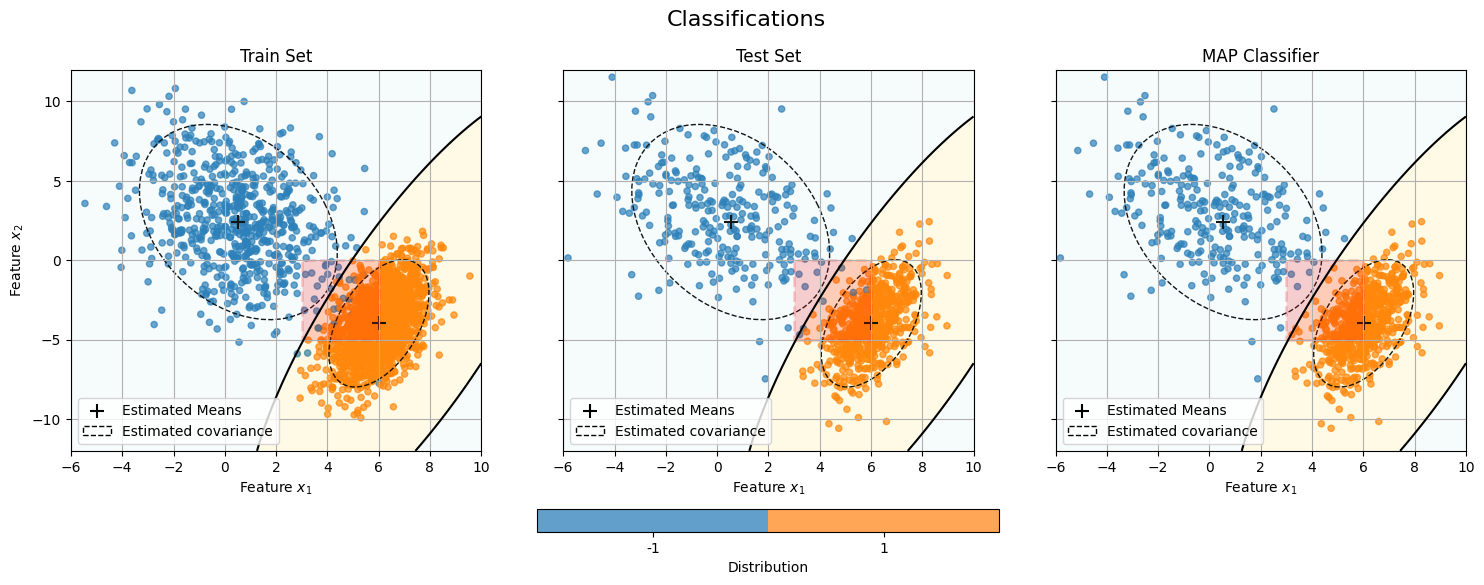

In [32]:
# Plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharex=True, sharey=True)
fig.suptitle("Classifications", fontsize=16)

for ax, classifications, title in zip(
    axs, 
    (train_samples, test_samples, assignments),
    ("Train Set", "Test Set", "MAP Classifier")
):
    classifications.plot.scatter(
        x="x1", y="x2", 
        c="distribution", colormap=cmap_distribution, colorbar=False,
        title=title, 
        ax=ax, grid=True, alpha=0.7,
    )

    ax.scatter(
        mean_estimates["x1"], 
        mean_estimates["x2"], 
        color="black", marker="+", s=100, label="Estimated Means"
    )

    for class_value in mean_estimates.index:
        mean = mean_estimates.loc[class_value].values
        cov = covariance_estimates.loc[class_value].values.reshape(2, 2)
        mahanalobis_ellipse(
            mean, 
            cov, 
            ax=ax, 
            edgecolor="black", 
            facecolor="none", 
            linestyle="--", 
            label=f"Estimated covariance" * (class_value == 1)  # only label once
        )

    # Red rectangle around the misslabeled samples
    ax.add_patch(Rectangle((3, -5), 3, 5, facecolor="red", ec="red", alpha=0.2, linestyle="--", linewidth=2))

    # Decision boundary
    ax.contour(X1, X2, G, levels=[0], colors="black") 
    ax.contourf(X1, X2, G, levels=[-1e9,0], colors=["lightblue"], alpha=0.1) # class -1 chosen
    ax.contourf(X1, X2, G, levels=[0,1e9], colors=["gold"], alpha=0.1) # class +1 chosen

    ax.legend(loc="lower left")
    ax.set_xlabel("Feature $x_1$")
    ax.set_ylabel("Feature $x_2$")

# Colorbar adjustment
cb = plt.colorbar(axs[0].collections[0], ticks=[-0.5, 0.5], ax=axs[:], orientation="horizontal", fraction=0.05, pad=0.125)
cb.set_ticklabels([-1, 1])
cb.set_label("Distribution")

Given the shapes and orientations of the train distributions, the boundary observed above seems reasonable.\
Moreover, given the good results in the last section, it prove itself useful during the test;
whether the classifier would still present good results with further data is unknown, but it would be fair to say that, should bad results appear,\
one should consider flaws in the sampling process (noise, distributions different than the ones obsreved before, etc) as much as flaws on the classifier design\
(e.g., change criterion, change parameter estimators).